In [2]:
import datasets

import nibabel as nib
import os
import pickle
import pandas as pd
import seaborn as sns
import numpy as np

import draw_results
import gene_analysis
import removing_confound
import meta_roi
import meta_voxel
import meta_vertex
import meta_confound
import correlation
from mask import Mask, NiiMask

D:\Software\conda\envs\meta\lib\site-packages\nilearn\datasets\__init__.py:89: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


# Site counts

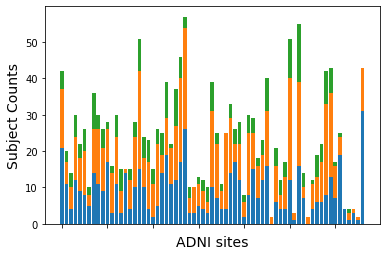

In [2]:
# calculate ADNI true site counts
import datasets
from collections import Counter
import seaborn as sns

fontsize = 14

tmp_centers = datasets.load_centers_adni()
sites = {}
for center in tmp_centers:
    persons = center.persons
    for person in persons:
        site = person.filename[:3]
        if site not in sites:
            sites[site] = [0, 0, 0]
        values = sites[site]
        values[person.label] += 1
        sites[site] = values


import pandas as pd
df = pd.DataFrame.from_dict(sites, orient='index')
sorted_df = df.sort_index()
nc = sorted_df.values.T[0]
mc = sorted_df.values.T[1]
ad = sorted_df.values.T[2]

import matplotlib.pyplot as plt
ticks = range(len(nc))
fig, ax = plt.subplots(1, 1)
ax.bar(ticks, nc, label='NC')
ax.bar(ticks, mc, bottom=nc, label='MCI')
ax.bar(ticks, ad, bottom=nc+mc, label='AD')
ax.set_xticklabels([])
ax.set_ylabel('Subject Counts', fontsize=fontsize)
ax.set_xlabel('ADNI sites', fontsize=fontsize)
plt.show()
plt.close()

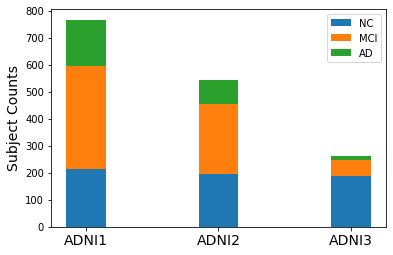

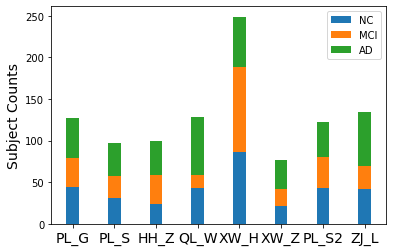

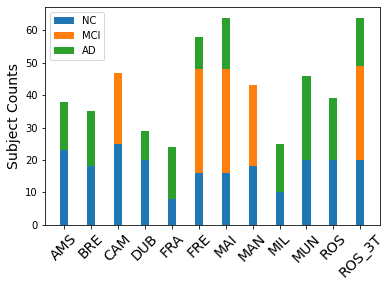

In [3]:
import numpy as np
def plot_center_counts(xlabels, centers, width=0.3, fontsize=14, rotate=False, rotation=45):
    nc = []
    mc = []
    ad = []
    for center in centers:
        nc.append(len(center.get_by_label(0)))
        mc.append(len(center.get_by_label(1)))
        ad.append(len(center.get_by_label(2)))
    nc = np.array(nc)
    mc = np.array(mc)
    ad = np.array(ad)
    ticks = range(len(sites))
    fig, ax = plt.subplots(1, 1)
    ax.bar(ticks, nc, width=width, label='NC')
    ax.bar(ticks, mc, width=width, bottom=nc, label='MCI')
    ax.bar(ticks, ad, width=width, bottom=nc+mc, label='AD')
    ax.set_xticks(ticks)
    ax.set_xticklabels(sites, fontsize=14)
    ax.set_ylabel('Subject Counts', fontsize=fontsize)
    ax.legend()
    if rotate:
        plt.xticks(rotation=rotation)
    plt.show()
    plt.close()
sites = ['ADNI1', 'ADNI2', 'ADNI3']
centers = datasets.load_centers_adni()
plot_center_counts(sites, centers)

sites = ['PL_G', 'PL_S', 'HH_Z', 'QL_W', 'XW_H', 'XW_Z', 'PL_S2', 'ZJ_L']
centers = datasets.load_centers_mcad()
plot_center_counts(sites, centers)

sites = ['AMS', 'BRE', 'CAM', 'DUB', 'FRA', 'FRE', 'MAI', 'MAN', 'MIL',
         'MUN', 'ROS', 'ROS_3T']
centers = datasets.load_centers_edsd()
plot_center_counts(sites, centers, rotate=True)

# Check Image quality

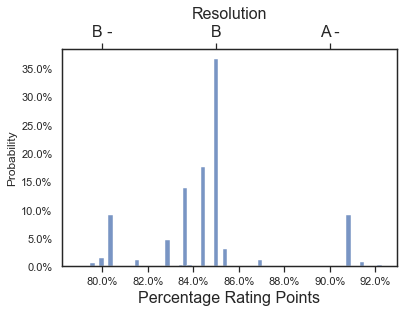

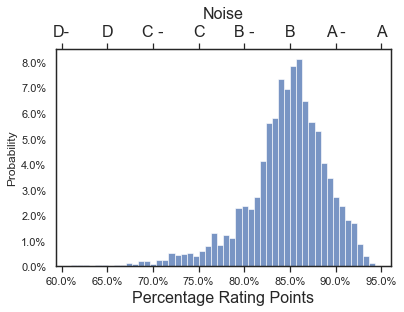

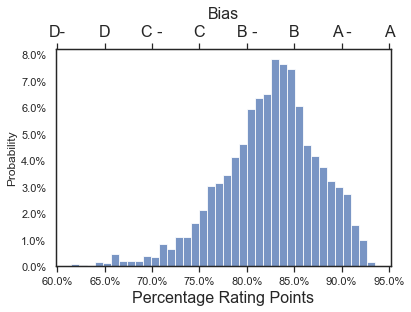

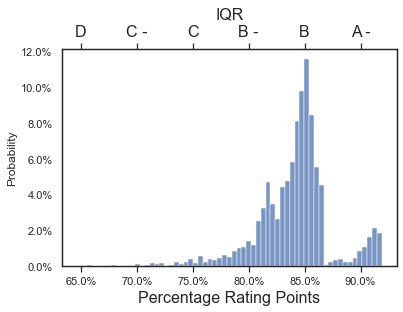

In [4]:
centers = datasets.load_centers_all()
sns.set_theme(style='white')

# Plot image preporcessed quality
image_qualities = 0
for center in centers:
    q, _ = center.get_image_quality()
    if np.size(q) != 1:
        if isinstance(image_qualities, int):
            image_qualities = q
        else:
            image_qualities = np.concatenate((image_qualities, q), axis=0)
image_qualities = image_qualities / 10
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick

titles = ['Resolution', 'Noise', 'Bias', 'IQR']
fontsize = 16
for i in range(4):
    fig, ax = plt.subplots()
    
    ax = sns.histplot(image_qualities[:, i], ax=ax, stat="probability")
    ax.set_title(titles[i], fontsize=fontsize)
    ax.set_xlabel('Percentage Rating Points', fontsize=fontsize)
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

    ax2 = ax.twiny()

    ax1Ticks = ax.get_xticks()
    ax2Ticks = ax1Ticks

    ax2.set_xticks([0.25,0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1])
    ax2.set_xbound(ax.get_xbound())
    ax2.set_xticklabels(['F', 'E', 'D-','D', 'C -','C', 'B -' ,'B', 
                        'A -' ,'A', 'A+'], fontsize=fontsize)
    plt.show()

In [10]:
# Check image quality ttest
def load_values(centers, label, axis=0):
    a = 0
    for center in centers:
        q, _ = center.get_image_quality(label=label)
        if np.size(q) != 1:
            if isinstance(a, int):
                a = q
            else:
                a = np.concatenate((a, q), axis=axis)
    return a 

import scipy
a = load_values(centers, 2, 0)
b = load_values(centers, 0, 0)

t, p = scipy.stats.ttest_ind(a[:,1], b[:,1])
print(t, p)

-4.293958726386198 1.8488548645037215e-05


# Meta by gender

In [ ]:
gs = ['male', 'female']
cs = ['mcad', 'edsd', 'adni']
for center in cs:
    if center == 'mcad':
        centers = datasets.load_centers_mcad()
    elif center == 'edsd':
        centers = datasets.load_centers_edsd()
    elif center == 'adni':
        centers = datasets.load_centers_adni()
    for gender in gs:
        if gender == 'male':
            ismale = 1
        else:
            ismale = 0
        meta_roi.create_csv_for_meta(centers, 2, 0,
                                    csv_prefix='roi_gmv',
                                    out_path='./data/meta_csv/{}/{}'.format(center, gender),
                                    gender=ismale)
        meta_roi.meta_gmv(2, 0, mask,
                        csv_dir='./data/meta_csv/{}/{}'.format(center, gender),
                        csv_prefix='roi_gmv',
                        out_dir='./results/meta/{}/{}'.format(center, gender))

# AAL and Sch Atlas

In [5]:
from mask import GiiMask, NiiMask
import datasets
"""
centers = datasets.load_centers_all()
gii_mask = GiiMask('./data/mask/mesh.intensity_aal.Template_T1_IXI555_MNI152_GS.gii')
gii_mask2 = GiiMask('./data/mask/mesh.intensity_Schaefer_1000_1mm.Template_T1_IXI555_MNI152_GS.gii')

for center in centers:
    center.create_rct_csv_by_gii(gii_mask, csv_dirname='aal_ct')
    center.create_rct_csv_by_gii(gii_mask2, csv_dirname='schaefer_ct')
"""
# %%
import meta_roi
label_pairs = [(2,0), (2,1), (1,0)]
csv_prefixs = ['aal', 'aal_ct', 'roi_gmv_schaefer', 'schaefer_ct']
out_prefix = './data/meta_csv/suppment'

## Create csv for meta analysis
for csv_prefix in csv_prefixs:
    for label_pair in label_pairs:
        label_eg = label_pair[0]
        label_cg = label_pair[1]
        meta_roi.create_csv_for_meta(centers, label_eg, label_cg, csv_prefix,
                                        out_path=out_prefix)
# %%
mask1 = NiiMask('./data/mask/aal.nii')
mask2 = NiiMask('./data/mask/Schaefer_1000_1mm.nii')
for label_pair in label_pairs:
    label_eg = label_pair[0]
    label_cg = label_pair[1]
    # GMV meta-analysis
    meta_roi.meta_gmv(label_eg, label_cg, mask1, csv_prefix='aal',
                csv_dir='./data/meta_csv/suppment',
                out_dir='./results/supp',
                count=116)
    meta_roi.meta_gmv(label_eg, label_cg, mask2, csv_prefix='roi_gmv_schaefer',
                csv_dir='./data/meta_csv/suppment',
                out_dir='./results/supp', count=1000)
    # CT 
    meta_roi.meta_ct(label_eg, label_cg, mask=mask1, csv_prefix='aal_ct',
                     csv_dir_prefix='./data/meta_csv/suppment',
                     out_dir_prefix='./results/supp',
                     save_gii=False, save_nii=True, count=116)
    meta_roi.meta_ct(label_eg, label_cg, mask=mask2, csv_prefix='schaefer_ct',
                     csv_dir_prefix='./data/meta_csv/suppment',
                     out_dir_prefix='./results/supp',
                     save_gii=False, save_nii=True, count=1000)

# Single Datasets

In [6]:
# %%
# perform meta-analysis
## ROI
csv_prefixs = ['roi_gmv_removed' ,'roi_ct_removed']
mcad = datasets.load_centers_mcad()
edsd = datasets.load_centers_edsd()
adni = datasets.load_centers_adni()
races = [mcad, edsd, adni]
names = ['mcad', 'edsd', 'adni']
mask = NiiMask('./data/mask/rBN_Atlas_246_1mm.nii')

### Create csv for meta analysis
for csv_prefix in csv_prefixs:
    for label_pair in label_pairs:
        label_eg = label_pair[0]
        label_cg = label_pair[1]
        for race, name in zip(races, names):
            meta_roi.create_csv_for_meta(race, label_eg, label_cg, csv_prefix,
                                    out_path='./data/meta_csv/suppment/{}'.format(name))

for label_pair in label_pairs:
    label_eg = label_pair[0]
    label_cg = label_pair[1]
    for race, name in zip(races, names):
        meta_roi.meta_gmv(label_eg, label_cg, mask, csv_prefix='roi_gmv_removed',
            csv_dir='./data/meta_csv/suppment/{}'.format(name),
            out_dir='./results/supp/{}'.format(name))

        meta_roi.meta_ct(label_eg, label_cg, mask=mask, csv_prefix='roi_ct_removed',
                        csv_dir_prefix='./data/meta_csv/suppment/{}'.format(name),
                        out_dir_prefix='./results/supp/{}'.format(name),
                        save_gii=False, save_nii=True)

# PLSR Single dataset

In [5]:
n_perm_boot = 5000
n_components = 5

label_pairs = [(2,0)]

mcad = datasets.load_centers_mcad()
edsd = datasets.load_centers_edsd()
adni = datasets.load_centers_adni()
races = [mcad, edsd, adni]
names = ['mcad', 'edsd', 'adni']
mask = NiiMask('./data/mask/rBN_Atlas_246_1mm.nii')

for name in names:
    for label_pair in label_pairs:
        label_eg = label_pair[0]
        label_cg = label_pair[1]
        out_dir ='./results/supp/{}'.format(name)

        roi_gmv_models = meta_roi.meta_gmv(label_eg, label_cg, mask,
        csv_dir='./data/meta_csv/suppment/{}'.format(name),
        out_dir='./results/supp/{}'.format(name),
         save_nii=False)
        roi_ct_models = meta_roi.meta_ct(label_eg, label_cg,
        csv_dir_prefix='./data/meta_csv/suppment/{}'.format(name),
        out_dir_prefix='./results/supp/{}'.format(name),
         save_gii=False, save_nii=False)
        
        gmv_es_dict = {}
        for k,v in sorted(roi_gmv_models.items()):
            gmv_es_dict[int(k)] = v.total_effect_size
            
        ct_es_dict = {}
        for k,v in sorted(roi_ct_models.items()):
            ct_es_dict[int(k)] = v.total_effect_size
        print('model calculated')
        gmv_plsr = gene_analysis.plsr(gmv_es_dict, n_components=n_components,
                                    n_perm=n_perm_boot, n_boot=n_perm_boot,
                                    out_path=os.path.join(out_dir, 'plsr_gmv.csv'))
        print('GMV Finished')
        ct_plsr = gene_analysis.plsr(ct_es_dict, n_components=n_components,
                                    n_perm=n_perm_boot, n_boot=n_perm_boot,
                                    out_path=os.path.join(out_dir, 'plsr_ct.csv'))

        with open(os.path.join(out_dir, 'plsr_gmv.pickle'), 'wb') as f:
            pickle.dump(gmv_plsr, f)
        with open(os.path.join(out_dir, 'plsr_ct.pickle'), 'wb') as f:
            pickle.dump(ct_plsr, f)

model calculated


GMV Finished


model calculated


GMV Finished


model calculated


GMV Finished


In [8]:
import pandas as pd
from scipy.stats import pearsonr
import numpy as np

feature_names = ['gmv', 'ct']
for feature_name in feature_names:
    main_path = f'./results/gene/2_0/plsr_{feature_name}.csv'
    main_df = pd.read_csv(main_path, index_col=0)
    main_values = main_df['pls1'].values

    names = ['mcad', 'edsd', 'adni']
    for name in names:
        sub_path = f'./results/supp/{name}/plsr_{feature_name}.csv'
        sub_df = pd.read_csv(sub_path, index_col=0)
        sub_values = sub_df['pls1'].values
        r, p = pearsonr(main_values, sub_values)
        print(feature_name, name, np.abs(r))

gmv mcad 0.9863712917672366
gmv edsd 0.9933489672712599
gmv adni 0.9633176154640523
ct mcad 0.9470797399298456
ct edsd 0.9792090843175273
ct adni 0.8426316060715331


# Left-right asy

In [3]:
mask_path = './data/mask/rBN_Atlas_246_1mm.nii'
mask = NiiMask(mask_path)

label_pairs = [(2,0), (2,1), (1,0)]

centers = datasets.load_centers_all()

prefixs = ['roi_gmv', 'roi_gmv_removed', 'roi_ct', 'roi_ct_removed']
for i in range(3):
    for prefix in prefixs:
        if 'gmv' in prefix:
            meta_roi.create_csv_for_meta_asy(centers, i, prefix, template=mask)
        else:
            meta_roi.create_csv_for_meta_asy(centers, i, prefix)
        meta_roi.meta_gmv_asy(i, mask, csv_prefix=prefix)

# MMSE result correlation with Meta

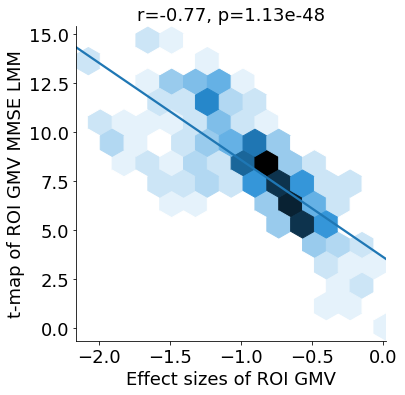

In [2]:
# load MMSE results
import meta_roi
mask_path = './data/mask/rBN_Atlas_246_1mm.nii'
mask = NiiMask(mask_path)
# load META results
roi_models = meta_roi.meta_gmv(2, 0, mask, save_nii=False)
values1 = [v.total_effect_size for k,v in sorted(roi_models.items())]

import mixed_lm
# ROI is model's eighth variable
stat_position = 8
gmv_models = mixed_lm.load_models('./results/mixedLM/gmv')
gmv_tvalues = mixed_lm.get_tvalues(gmv_models, i=stat_position)
values2 = [v for k,v in sorted(gmv_tvalues.items())]

draw_results.plot_correlation_joint(values1, values2,
        'Effect sizes of ROI GMV', 't-map of ROI GMV MMSE LMM', fontsize=18, show=True,
        save=False)

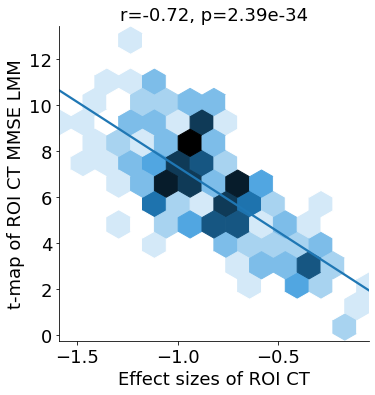

In [16]:
# load MMSE results
import meta_roi
mask_path = './data/mask/rBN_Atlas_246_1mm.nii'
mask = NiiMask(mask_path)
# load META results
roi_models = meta_roi.meta_ct(2, 0, mask, save_nii=False, save_gii=False)
values1 = [v.total_effect_size for k,v in sorted(roi_models.items()) if int(k)<211]

import mixed_lm
# ROI is model's eighth variable
stat_position = 8
gmv_models = mixed_lm.load_models('./results/mixedLM/ct')
gmv_tvalues = mixed_lm.get_tvalues(gmv_models, i=stat_position)
values2 = [v for k,v in sorted(gmv_tvalues.items()) if int(k)<211]

draw_results.plot_correlation_joint(values1, values2,
        'Effect sizes of ROI CT', 't-map of ROI CT MMSE LMM', fontsize=18, show=True,
        save=False)

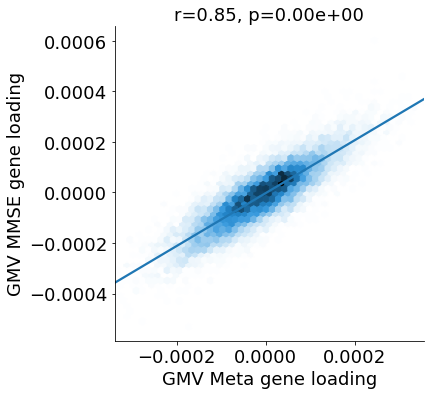

In [3]:
csv_path_1 = r'./results/gene/2_0/plsr_gmv.csv'
csv_paht_2 = r'./results/mixedLM/gene/plsr_gmv.csv'
df1 = pd.read_csv(csv_path_1)
df2 = pd.read_csv(csv_paht_2)
df = df1.merge(df2, on='gene_name')
values1 = df['pls1_x']
values2 = df['pls1_y']
draw_results.plot_correlation_joint(values1, values2,
        'GMV Meta gene loading', 'GMV MMSE gene loading', fontsize=18, show=True,
        save=False)

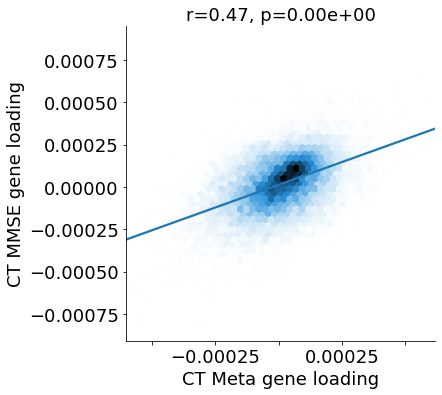

In [13]:
import draw_results
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
csv_path_1 = r'./results/gene/2_0/plsr_ct.csv'
csv_paht_2 = r'./results/mixedLM/gene/plsr_ct.csv'
df1 = pd.read_csv(csv_path_1)
df2 = pd.read_csv(csv_paht_2)
df = df1.merge(df2, on='gene_name')
values1 = df['pls1_x']
values2 = df['pls1_y']

x_label = 'CT Meta gene loading'
y_label = 'CT MMSE gene loading'

fontsize=18
r, p = pearsonr(values1, values2)
df = pd.DataFrame(
                {x_label: values1,
                y_label: values2,
                })

g = sns.jointplot(x=x_label, y=y_label, data=df, kind="hex")
sns.regplot(x=x_label, y=y_label, data=df, scatter=False,
            ci=None, ax=g.ax_joint)
g.ax_marg_x.remove()
g.ax_marg_y.remove()

g.ax_joint.tick_params(axis='both', which='major', labelsize=fontsize)
g.set_axis_labels(x_label, y_label, fontsize=fontsize)
"""
for item in g.ax_joint.get_xticklabels():
    item.set_rotation(45)
"""
every_nth = 2
for n, label in enumerate(g.ax_joint.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

plt.title('r={:.2f}, p={:.2e}'.format(r, p), 
          fontdict={'fontsize': fontsize})
plt.show()
plt.close()



c:\users\dunge\anaconda3\envs\meta\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10
c:\users\dunge\anaconda3\envs\meta\lib\site-packages\ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


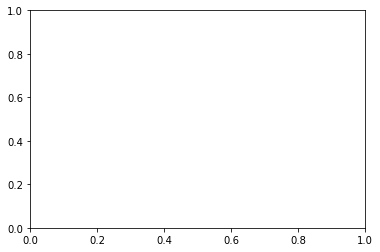

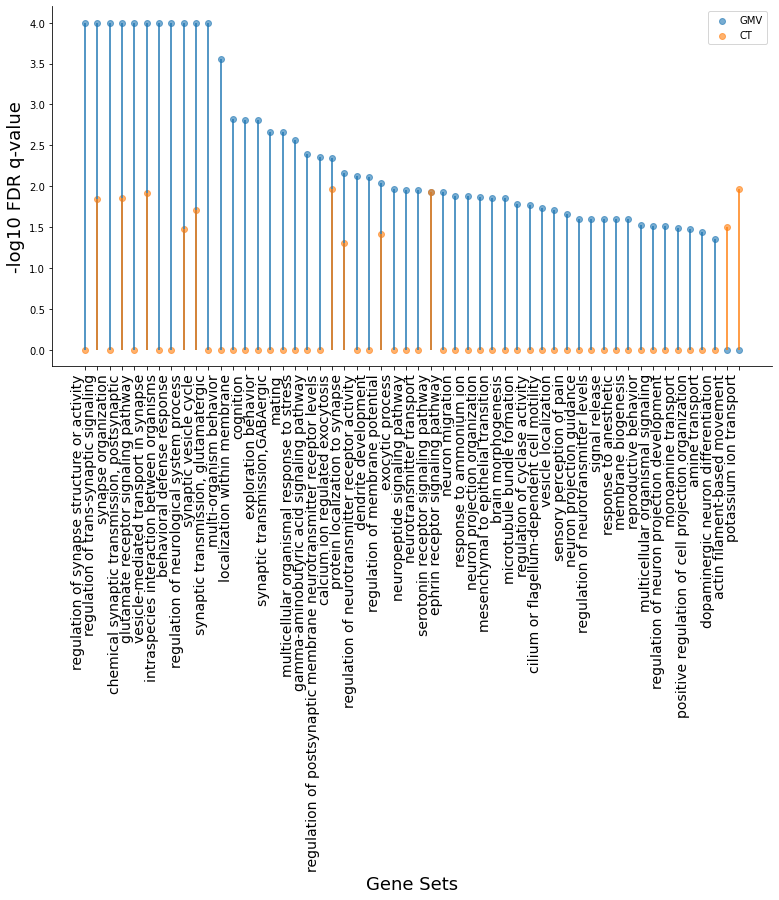

In [13]:
import pandas as pd
df1 = pd.read_csv(r'./results\mixedLM\gene\webGestalt\GO_Bio_05_gmv\enrichment_results.csv', index_col=1)
df2 = pd.read_csv(r'./results\mixedLM\gene\webGestalt\GO_Bio_05_ct\enrichment_results.csv', index_col=1)
df = df1.merge(df2, how='outer', left_on='description', right_on='description',
          suffixes=('_gmv', '_ct'))
df = df.fillna(10)
df = df.sort_values('FDR_gmv', ascending=False)
import numpy as np
import matplotlib.pyplot as plt

fontsize=18
alpha=0.6
fig_width=10
fig_height=5

y = range(len(df.index), 0, -1)
values = -np.log10(df['FDR_gmv'].to_numpy())
sub_values = -np.log10(df['FDR_ct'].to_numpy())
values[values==np.inf] = 4
sub_values[sub_values==np.inf] = 4
values[values==-1] = 0
sub_values[sub_values==-1] = 0
y_labels = df.index.to_numpy().tolist()

fig, ax = plt.subplots()
fig = plt.figure(figsize=(fig_width, fig_height))
ax = fig.add_axes([0, 0, 1, 1])

ax.scatter(x=y, y=values, label='GMV', alpha=alpha)
ax.vlines(x=y, ymin=0, ymax=values)
ax.scatter(x=y, y=sub_values, label='CT', alpha=alpha)
ax.vlines(x=y, ymin=0, ymax=sub_values, color='C1')

ax.set_xticks(y)
ax.set_xticklabels(y_labels, {'fontsize': 14}, ha='right')
ax.set_ylabel('-log10 FDR q-value', fontsize=fontsize)
ax.set_xlabel('Gene Sets', fontsize=fontsize)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for item in ax.get_xticklabels():
    item.set_rotation(90)

plt.draw()

ax.legend()
plt.show()
plt.close()

# LMM supplement

In [2]:
import mixed_lm
import datasets
import warnings
warnings.filterwarnings('ignore')

centers = datasets.load_centers_all()
all_df_gmv = mixed_lm.load_data(centers, csv_prefix='roi_gmv/{}.csv')
# age* diagnose
#mixed_lm.mixed_lm_supp1(all_df_gmv, out_dir='./results/supp/mixedLM/gmv_aged')
# gender* diagnose
#mixed_lm.mixed_lm_supp2(all_df_gmv, out_dir='./results/supp/mixedLM/gmv_genderd')
# age^2
mixed_lm.mixed_lm_supp3(all_df_gmv, out_dir='./results/supp/mixedLM/gmv_age2')

all_df_ct = mixed_lm.load_data(centers, csv_prefix='roi_ct/{}.csv')
mixed_lm.mixed_lm_supp1(all_df_ct, out_dir='./results/supp/mixedLM/ct_aged', value_range=211)
#mixed_lm.mixed_lm_supp2(all_df_ct, out_dir='./results/supp/mixedLM/ct_genderd', value_range=211)
mixed_lm.mixed_lm_supp3(all_df_ct, out_dir='./results/supp/mixedLM/ct_age2', value_range=211)

Fitting ROI:1
Fitting ROI:2
Fitting ROI:3
Fitting ROI:4
Fitting ROI:5
Fitting ROI:6
Fitting ROI:7
Fitting ROI:8
Fitting ROI:9
Fitting ROI:10
Fitting ROI:11
Fitting ROI:12
Fitting ROI:13
Fitting ROI:14
Fitting ROI:15
Fitting ROI:16
Fitting ROI:17
Fitting ROI:18
Fitting ROI:19
Fitting ROI:20
Fitting ROI:21
Fitting ROI:22
Fitting ROI:23
Fitting ROI:24
Fitting ROI:25
Fitting ROI:26
Fitting ROI:27
Fitting ROI:28
Fitting ROI:29
Fitting ROI:30
Fitting ROI:31
Fitting ROI:32
Fitting ROI:33
Fitting ROI:34
Fitting ROI:35
Fitting ROI:36
Fitting ROI:37
Fitting ROI:38
Fitting ROI:39
Fitting ROI:40
Fitting ROI:41
Fitting ROI:42
Fitting ROI:43
Fitting ROI:44
Fitting ROI:45
Fitting ROI:46
Fitting ROI:47
Fitting ROI:48
Fitting ROI:49
Fitting ROI:50
Fitting ROI:51
Fitting ROI:52
Fitting ROI:53
Fitting ROI:54
Fitting ROI:55
Fitting ROI:56
Fitting ROI:57
Fitting ROI:58
Fitting ROI:59
Fitting ROI:60
Fitting ROI:61
Fitting ROI:62
Fitting ROI:63
Fitting ROI:64
Fitting ROI:65
Fitting ROI:66
Fitting ROI:67
Fitt

Fitting ROI:76
Fitting ROI:77
Fitting ROI:78
Fitting ROI:79
Fitting ROI:80
Fitting ROI:81
Fitting ROI:82
Fitting ROI:83
Fitting ROI:84
Fitting ROI:85
Fitting ROI:86
Fitting ROI:87
Fitting ROI:88
Fitting ROI:89
Fitting ROI:90
Fitting ROI:91
Fitting ROI:92
Fitting ROI:93
Fitting ROI:94
Fitting ROI:95
Fitting ROI:96
Fitting ROI:97
Fitting ROI:98
Fitting ROI:99
Fitting ROI:100
Fitting ROI:101
Fitting ROI:102
Fitting ROI:103
Fitting ROI:104
Fitting ROI:105
Fitting ROI:106
Fitting ROI:107
Fitting ROI:108
Fitting ROI:109
Fitting ROI:110
Fitting ROI:111
Fitting ROI:112
Fitting ROI:113
Fitting ROI:114
Fitting ROI:115
Fitting ROI:116
Fitting ROI:117
Fitting ROI:118
Fitting ROI:119
Fitting ROI:120
Fitting ROI:121
Fitting ROI:122
Fitting ROI:123
Fitting ROI:124
Fitting ROI:125
Fitting ROI:126
Fitting ROI:127
Fitting ROI:128
Fitting ROI:129
Fitting ROI:130
Fitting ROI:131
Fitting ROI:132
Fitting ROI:133
Fitting ROI:134
Fitting ROI:135
Fitting ROI:136
Fitting ROI:137
Fitting ROI:138
Fitting ROI:139


In [3]:
import mixed_lm
from mask import Mask, NiiMask
# load mask to save values
mask_path = './data/mask/rBN_Atlas_246_1mm.nii'
mask = NiiMask(mask_path)
# ROI is model's eighth variable
stat_position = 8
p = 1
correction = False

# Save significant t-map
gmv_models = mixed_lm.load_models('./results/supp/mixedLM/gmv_aged')
gmv_tvalues, gmv_pvalues = mixed_lm.get_stats(gmv_models, i=stat_position, p=p, correction=correction)
mixed_lm.save_t_nii(gmv_tvalues, mask, './results/supp/mixedLM/gmv_aged.nii')

ct_models = mixed_lm.load_models('./results/supp/mixedLM/ct_aged')
ct_tvalues, ct_pvalues = mixed_lm.get_stats(ct_models, i=stat_position, p=p, correction=correction)
mixed_lm.save_t_nii(ct_tvalues, mask, './results/supp/mixedLM/ct_aged.nii')

gmv_models = mixed_lm.load_models('./results/supp/mixedLM/gmv_age2')
gmv_tvalues, gmv_pvalues = mixed_lm.get_stats(gmv_models, i=stat_position, p=p, correction=correction)
mixed_lm.save_t_nii(gmv_tvalues, mask, './results/supp/mixedLM/gmv_age2.nii')

ct_models = mixed_lm.load_models('./results/supp/mixedLM/ct_age2')
ct_tvalues, ct_pvalues = mixed_lm.get_stats(ct_models, i=stat_position, p=p, correction=correction)
mixed_lm.save_t_nii(ct_tvalues, mask, './results/supp/mixedLM/ct_age2.nii')

# list Abeta/FDG detail

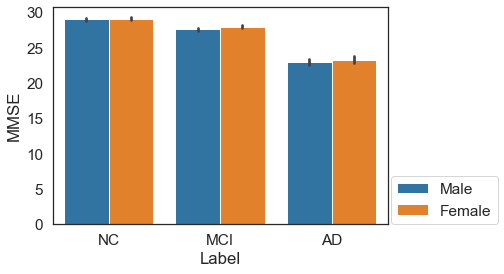

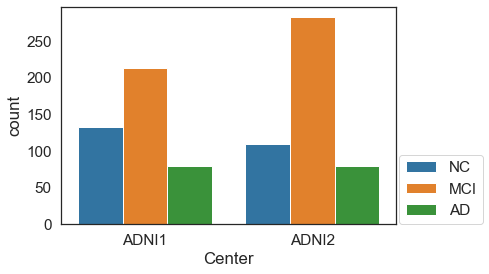

In [35]:
import pet_fdg
import seaborn as sns
from mask import NiiMask

subject_df = pet_fdg.create_subject_df()
"""
mask_path = './data/mask/BN_Atlas_246_1mm.nii'
mask = NiiMask(mask_path)
pet_fdg.create_sum(subject_df, mask)
"""

def label_gender(row):
    if row['male'] == 1:
        return 'Male'
    if row['male'] == 0:
        return 'Female'

def label_label(row):
    if row['Label'] == 0:
        return 'NC'
    if row['Label'] == 1:
        return 'MCI'
    if row['Label'] == 2:
        return 'AD'

subject_df['gender'] = subject_df.apply(lambda row: label_gender(row), axis=1)
subject_df['Label'] = subject_df.apply(lambda row: label_label(row), axis=1)
subject_df['Center'] = subject_df['center']

sns.set(font_scale = 1.4)
sns.set_style("white")

ax = sns.barplot(x='Label', y='MMSE', hue='gender', data=subject_df, palette="tab10")
ax.legend(loc=(1.01,0))
plt.show()
plt.close()
ax2 = sns.countplot(x="Center", data=subject_df, hue='Label', palette="tab10")
ax2.legend(loc=(1.01,0))
plt.show()
plt.close()

In [8]:
len(subject_df)

894

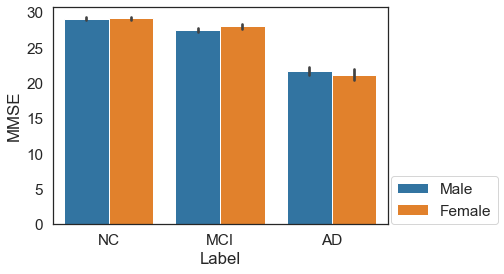

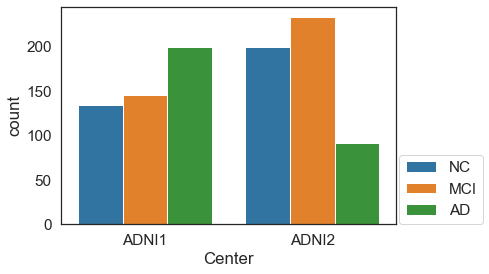

In [37]:
import abeta_pet
import seaborn as sns
import matplotlib.pyplot as plt

subject_df = abeta_pet.create_subject_df()

def label_gender(row):
    if row['male'] == 1:
        return 'Male'
    if row['male'] == 0:
        return 'Female'

def label_label(row):
    if row['Label'] == 0:
        return 'NC'
    if row['Label'] == 1:
        return 'MCI'
    if row['Label'] == 2:
        return 'AD'

subject_df = subject_df.sort_values('Label')
subject_df['gender'] = subject_df.apply(lambda row: label_gender(row), axis=1)
subject_df['Label'] = subject_df.apply(lambda row: label_label(row), axis=1)
subject_df['Center'] = subject_df['center']


sns.set(font_scale = 1.4)
sns.set_style("white")
ax = sns.barplot(x='Label', y='MMSE', hue='gender', data=subject_df, palette="tab10")

ax.legend(loc=(1.01,0))
plt.show()
plt.close()
sns.set_style("white")
ax2 = sns.countplot(x="Center", data=subject_df, hue='Label', palette="tab10")
ax2.legend(loc=(1.01,0))
plt.show()
plt.close()

In [12]:
subject_df.head()

,Name,center,MMSE,Label,male,1,2,3,4,5,...,237,238,239,240,241,242,243,244,245,246
0,002_S_0295,ADNI1,28,0,1,20414.193244,28115.047470,26192.283711,26634.517533,10216.543123,...,3819.664736,4599.456669,6686.842945,6398.421629,5284.268557,3411.237983,2760.327680,3137.271591,10689.482253,5809.833664
1,002_S_0413,ADNI1,30,0,0,13921.673585,18278.655204,19257.165716,15146.944263,9439.633448,...,3569.434367,2782.434173,5102.605877,4661.334044,4616.011658,2675.461445,2694.666628,2038.184825,9203.131891,4046.740469
2,002_S_0685,ADNI1,28,0,0,18210.615666,20454.990889,20900.155469,16224.585154,13092.898547,...,3719.336299,3260.049088,4210.585910,4545.616163,4419.969920,2681.582040,3069.690350,2522.292959,8973.396480,3730.548355
3,002_S_0729,ADNI1,24,2,0,24830.809992,27249.049618,23913.948712,22286.058435,15141.159775,...,5102.697233,4588.656834,6330.548024,7063.515692,5869.111053,3728.499356,3867.079867,4362.546403,11396.256856,5725.441068
4,002_S_1261,ADNI1,30,0,0,16792.288407,19765.420943,24497.909761,17536.820476,12409.423611,...,3596.858965,3453.617779,4450.813710,4537.577655,4442.061667,2420.187151,2513.108033,2486.462845,10651.563734,4766.687988


In [10]:
len(subject_df)

1003

In [1]:
# 5HT1B gene PLSR

In [5]:
n_perm_boot = 1
n_components = 2
out_dir ='./results/gene/5HT1B'


df = pd.read_csv('./data/PET/masked_mean/5HT1b_P943_HC22.csv', index_col=0)
pet_values_dict = {}
for index, row in df.iterrows():
    pet_values_dict[index] = row['Volume']

plsr = gene_analysis.plsr(pet_values_dict, n_components=n_components,
                                n_perm=n_perm_boot, n_boot=n_perm_boot,
                                out_path=os.path.join(out_dir, 'plsr.csv'))

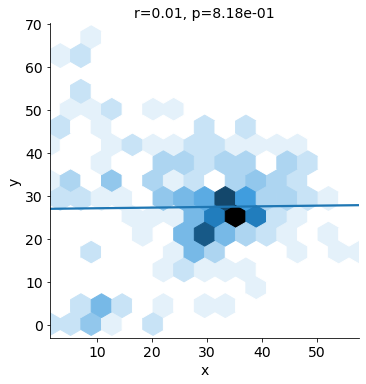

In [8]:
df = pd.read_csv('./data/PET/masked_mean/5HT1b_P943_HC22.csv', index_col=0)
df2 = pd.read_csv('./data/PET/masked_mean/5HT1a_WAY_HC36.csv', index_col=0)
draw_results.plot_correlation_joint(df.values.flatten(), df2.values.flatten())


# Voxelwise correlation (For supplementray)

In [12]:
import nibabel as nib
import numpy as np
from scipy.stats import pearsonr
def voxel_corr(path1, path2):
    nii1 = nib.load(path1)
    nii2 = nib.load(path2)
    array1 = np.array(nii1.dataobj).flatten()
    array2 = np.array(nii2.dataobj).flatten()
    array1 = np.nan_to_num(array1, nan=0, posinf=0, neginf=0)
    array2 = np.nan_to_num(array2, nan=0, posinf=0, neginf=0)
    r, p = pearsonr(array1, array2)
    return r, p



2_0
(0.7800091706616459, 0.0)
(0.7913415652045972, 0.0)
2_1
(0.716897909316555, 0.0)
(0.7590426629210828, 0.0)
1_0
(0.744503105904246, 0.0)
(0.7722713942231485, 0.0)
2_0
(0.7746828307683702, 0.0)
(0.7811937813331248, 0.0)
2_1
(0.714687822083825, 0.0)
(0.7419618925336329, 0.0)
1_0
(0.7333604574116604, 0.0)
(0.7582595392049802, 0.0)


## 其他图谱

In [ ]:
labels = ['2_0', '2_1', '1_0']
for label in labels:
    print(label)
    p1 = f'./results/meta/{label}/roi_gmv_removed/es.nii'
    sub_pathes = [f'./results/supp/{label}/roi_gmv_schaefer/es.nii', 
                f'./results/supp/{label}/aal/es.nii', ]
    for sub_path in sub_pathes:
        print(voxel_corr(p1, sub_path))

for label in labels:
    print(label)
    p1 = f'./results/meta/{label}/roi_ct_removed/es.nii'
    sub_pathes = [f'./results/supp/{label}/schaefer_ct/es.nii', 
                f'./results/supp/{label}/aal_ct/es.nii', ]
    for sub_path in sub_pathes:
        print(voxel_corr(p1, sub_path))

## 单中心

In [15]:
labels = ['2_0', '2_1', '1_0']
ds = [ 'mcad', 'edsd', 'adni']
print('GMV')
for label in labels:
    print(label)
    p1 = f'./results/meta/{label}/roi_gmv_removed/es.nii'
    for d in ds:
        sub_path = f'./results/supp/{d}/{label}/roi_gmv_removed/es.nii'
        print(d, voxel_corr(p1, sub_path))
print('CT')
for label in labels:
    print(label)
    p1 = f'./results/meta/{label}/roi_ct_removed/es.nii'
    for d in ds:
        sub_path = f'./results/supp/{d}/{label}/roi_ct_removed/es.nii'
        print(d, voxel_corr(p1, sub_path))


GMV
2_0
mcad (0.9936521990622659, 0.0)
edsd (0.9948913684430489, 0.0)
adni (0.9832238258947756, 0.0)
2_1
mcad (0.9959712591851648, 0.0)
edsd (0.8518088914252021, 0.0)
adni (0.9902172355627853, 0.0)
1_0
mcad (0.9611834150278002, 0.0)
edsd (0.9739561892679117, 0.0)
adni (0.9575482300753508, 0.0)
CT
2_0
mcad (0.9869424047745795, 0.0)
edsd (0.9873597872485955, 0.0)
adni (0.9699810812144966, 0.0)
2_1
mcad (0.993663254174295, 0.0)
edsd (0.9007191158132423, 0.0)
adni (0.9777428566074285, 0.0)
1_0
mcad (0.9663341172762603, 0.0)
edsd (0.9545228319527972, 0.0)
adni (0.9344708835937753, 0.0)
